<a href="https://colab.research.google.com/github/Matvej911/Matvejs_edgeAi/blob/main/emotion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall tensorflow -y


Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0


In [2]:
!pip install tensorflow==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: google-auth-oauthlib
    Found existing inst

In [36]:
import cv2
import os
import shutil
import random
import warnings

from keras.models import load_model
from keras.preprocessing import image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px






from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from IPython.display import clear_output

from google.colab.patches import cv2_imshow

warnings.filterwarnings('ignore')


In [12]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


### This section mounts your Google Drive to Colab so you can access files stored there.
### You need to grant permission when prompted, and your Google Drive will be available at `/content/drive`.

Before running the following code, please ensure you have uploaded your dataset to Google Drive. Follow these steps:

Prepare Your Dataset:

Make sure your dataset is in a zip file format, named emotion.zip.
The zip file should contain your training and validation images organized into separate directories for each emotion.
Upload to Google Drive:

Upload the emotion.zip file to your Google Drive. You can place it in any folder, but for simplicity, you might want to place it in the root directory of your Drive.

In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!cp "/content/drive/MyDrive/emotion/emotion.zip" /content/

In [15]:
import zipfile
import os

zip_path = '/content/emotion.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))

['.config', 'emot.zip', 'emot', 'drive', 'sample_data']



###!Remove Unwanted Classes Function
###!Reduce Class Images Function
###!Data Preprocessing
###!Define and Compile the Model
###!Training the Model
###!Fine-tuning the Model
The base layers of DenseNet121 are unfrozen (model.layers[1].trainable = True), allowing the model to fine-tune the pre-trained weights with a lower learning rate (SGD optimizer).
###!Model Saving

In [17]:
IMG_HEIGHT = 48
IMG_WIDTH = 48
batch_size = 32

def remove_unwanted_classes(data_dir, allowed_classes):
    for class_name in os.listdir(data_dir):
        if class_name not in allowed_classes:
            class_path = os.path.join(data_dir, class_name)
            if os.path.isdir(class_path):
                shutil.rmtree(class_path)


def reduce_class_images(class_dir, reduction_factor=0.6):

    all_images = os.listdir(class_dir)


    random.shuffle(all_images)

    num_images_to_remove = int(len(all_images) * reduction_factor)

    images_to_remove = all_images[:num_images_to_remove]
    for image in images_to_remove:
        image_path = os.path.join(class_dir, image)
        if os.path.isfile(image_path):
            os.remove(image_path)

allowed_classes = ['happy', 'sad']
train_data_dir = '/content/emotion/train'
validation_data_dir = '/content/emotion/test'


remove_unwanted_classes(train_data_dir, allowed_classes)
remove_unwanted_classes(validation_data_dir, allowed_classes)


happy_class_dir = os.path.join(train_data_dir, 'happy')
reduce_class_images(happy_class_dir, reduction_factor=0.5)


train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='rgb',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='rgb',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)


def define_compile_model():
    base_model = tf.keras.applications.DenseNet121(
        include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), pooling='avg')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


model = define_compile_model()
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=10,
                                                         verbose=1,
                                                         restore_best_weights=True)


history = model.fit(x=train_generator,
                    epochs=25,
                    validation_data=validation_generator,
                    callbacks=[earlyStoppingCallback])


model.layers[1].trainable = True
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine_tune = model.fit(x=train_generator,
                              epochs=10,
                              validation_data=validation_generator)


model.save("happy_sad_model.h5")


Found 4025 images belonging to 2 classes.
Found 3021 images belonging to 2 classes.
Epoch 1/25
126/126 [==============================] - 77s 534ms/step - loss: 0.6219 - accuracy: 0.6561 - val_loss: 0.5764 - val_accuracy: 0.6918
Epoch 2/25
126/126 [==============================] - 67s 531ms/step - loss: 0.5828 - accuracy: 0.6969 - val_loss: 0.5592 - val_accuracy: 0.7097
Epoch 3/25
126/126 [==============================] - 79s 628ms/step - loss: 0.5823 - accuracy: 0.6944 - val_loss: 0.5553 - val_accuracy: 0.7256
Epoch 4/25
126/126 [==============================] - 80s 640ms/step - loss: 0.5691 - accuracy: 0.6986 - val_loss: 0.5443 - val_accuracy: 0.7325
Epoch 5/25
126/126 [==============================] - 79s 626ms/step - loss: 0.5615 - accuracy: 0.7163 - val_loss: 0.5426 - val_accuracy: 0.7216
Epoch 6/25
126/126 [==============================] - 63s 498ms/step - loss: 0.5421 - accuracy: 0.7217 - val_loss: 0.5838 - val_accuracy: 0.6984
Epoch 7/25
126/126 [==========================

###Visualizing a Random Image with its Label from the Training Set

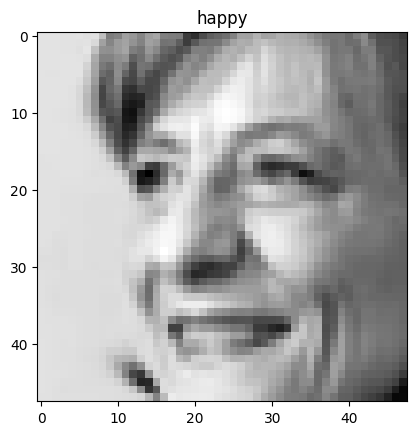

In [18]:
class_labels = ['happy', 'sad']

img, label = train_generator.__next__()

i = random.randint(0, img.shape[0] - 1)
image = img[i]
labl = class_labels[int(label[i])]
plt.imshow(image[:, :, 0], cmap='gray')
plt.title(labl)
plt.show()







###Plotting Training and Validation Loss Over Epochs

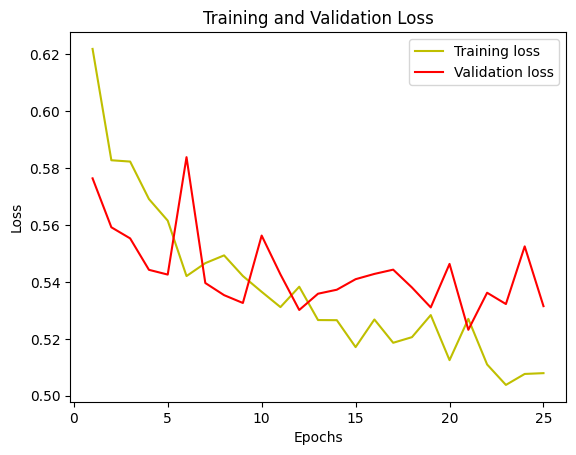

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)

plt.plot(epochs_range, loss, 'y', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

###Face Extraction and Resizing from an Image

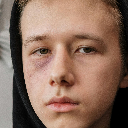

In [25]:
def extract_and_resize_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    image = cv2.imread(image_path)
    if image is None:
        print("Could not read the image.")
        return None

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces found.")
        return None


    (x, y, w, h) = faces[0]
    face_image = image[y:y + h, x:x + w]

    face_image_resized = cv2.resize(face_image, (128, 128))

    return face_image_resized

output_face = extract_and_resize_face('pexels-cottonbro-4100481.jpg')
if output_face is not None:
    cv2_imshow(output_face)
    cv2.imwrite('output_face.jpg', output_face)


###Emotion Prediction from Image

1/1 [==============================] - 4s 4s/step
The predicted emotion is: Sad Probability: 0.90


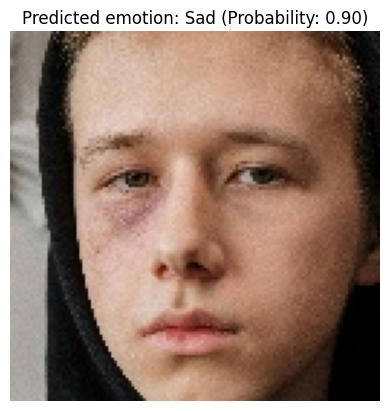

In [26]:
model = load_model('happy_sad_model.h5')

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (48, 48))
    img = img / 255.0
    img = np.reshape(img, (1, 48, 48, 3))
    return img


def predict_emotion(img_path):
    img = preprocess_image(img_path)
    prediction = model.predict(img)[0]
    probability = float(prediction[0])
    if probability > 0.5:
        emotion = "Sad"
    else:
        emotion = "Happy"
        probability = 1 - probability

    return emotion, probability

image_path = "/content/output_face.jpg"

emotion, probability = predict_emotion(image_path)
print(f"The predicted emotion is: {emotion} Probability: {probability:.2f}")

img = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted emotion: {emotion} (Probability: {probability:.2f})")
plt.axis('off')
plt.show()


###TensorFlow Lite Model Conversion

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

with open('happy_sad_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TFLite and saved as 'happy_sad_model.tflite'")


Model converted to TFLite and saved as 'happy_sad_model.tflite'


###TensorFlow Lite Model Inference
This code snippet shows how to perform inference using a TensorFlow Lite model, specifically for predicting emotions from images.

In [28]:
interpreter = tf.lite.Interpreter(model_path="/content/happy_sad_model.tflite")

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (48, 48))
    img = img / 255.0
    img = np.reshape(img, (1, 48, 48, 3)).astype(np.float32)
    return img


def predict_emotion(img_path):
    img = preprocess_image(img_path)

    interpreter.set_tensor(input_details[0]['index'], img)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    probability = output_data[0]

    if probability > 0.5:
        emotion = "Sad"
    else:
        emotion = "Happy"
        probability = 1 - probability

    return emotion, probability

image_path = "/content/output_face.jpg"
emotion, probability = predict_emotion(image_path)
print(f"The predicted emotion is: {emotion} Probability: {probability:.2f}")



The predicted emotion is: Sad Probability: 0.90


 ### Emotion Detection testing and metrics collecting

In [35]:
model = load_model('happy_sad_model.h5')

def preprocess_image(img):
    img = cv2.resize(img, (48, 48))
    img = img / 255.0
    img = np.reshape(img, (1, 48, 48, 3))
    return img

def predict_emotion(img):
    img_processed = preprocess_image(img)
    prediction = model.predict(img_processed)[0]
    probability = float(prediction[0])
    if probability > 0.5:
        emotion = "Sad"
    else:
        emotion = "Happy"
        probability = 1 - probability

    return emotion, probability

def extract_and_resize_face(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    image = cv2.imread(image_path)

    if image is None:
        print("Could not read the image.")
        return None

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces found.")
        return None

    (x, y, w, h) = faces[0]
    face_image = image[y:y + h, x:x + w]
    face_image_resized = cv2.resize(face_image, (128, 128))

    return face_image_resized

dataset_folder = '/content/images'

actual_labels = []
predicted_labels = []
probabilities = []


for filename in os.listdir(dataset_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        if 'sad' in filename:
            actual_emotion = 'Sad'
        elif 'happy' in filename:
            actual_emotion = 'Happy'
        else:
            continue


        image_path = os.path.join(dataset_folder, filename)


        face_image = extract_and_resize_face(image_path)

        if face_image is not None:
            emotion, probability = predict_emotion(face_image)


            actual_labels.append(actual_emotion)
            predicted_labels.append(emotion)
            probabilities.append(probability)

if actual_labels:
    results_df = pd.DataFrame({
        'Filename': [filename for filename in os.listdir(dataset_folder) if filename.endswith(('.jpg', '.png'))],
        'Actual Emotion': actual_labels,
        'Predicted Emotion': predicted_labels,
        'Probability': probabilities
    })

    results_df.to_csv('emotion_prediction_results.csv', index=False)

    print(confusion_matrix(actual_labels, predicted_labels))
    print(classification_report(actual_labels, predicted_labels))

    print(results_df)
else:
    print("No valid images were processed.")




1/1 [==============================] - 0s 60ms/step
[[9 1]
 [2 8]]
              precision    recall  f1-score   support

       Happy       0.82      0.90      0.86        10
         Sad       0.89      0.80      0.84        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20

          Filename Actual Emotion Predicted Emotion  Probability
0     m_69_sad.jpg            Sad               Sad     0.618850
1   w_26_happy.jpg          Happy               Sad     0.833407
2   m_31_happy.jpg          Happy             Happy     0.994261
3     w_20_sad.jpg            Sad               Sad     0.686067
4   w_53_happy.jpg          Happy             Happy     0.615668
5     w_10_sad.jpg            Sad               Sad     0.808580
6   w_63_happy.jpg          Happy             Happy     0.969756
7   w_57_happy.jpg          Happy             Happy     0.951811
8   w_23_happy.jpg   